# Korean Word2Vec

> ## 네이버 영화 리뷰 데이터

In [1]:
import warnings
warnings.filterwarnings('ignore')

# I. Install & Import Packages

* Install KoNLPy

In [2]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 56.8 MB/s 
     |████████████████████████████████| 86 kB 4.9 MB/s 
     |████████████████████████████████| 448 kB 82.5 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


* Import Packages

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# II. Data Preprocessing

> ## 1) naverRatings.zip

* Google Drive Mount

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/datasets/naverRatings.zip 

-rw------- 1 root root 7903524 Mar 31  2021 '/content/drive/My Drive/Colab Notebooks/datasets/naverRatings.zip'


In [6]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/naverRatings.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/naverRatings.zip
  inflating: naverRatings.txt        


In [7]:
!ls -l naverRatings.txt

-rw-r--r-- 1 root root 19515078 May  4  2020 naverRatings.txt


> ## 2) 데이터 읽어오기

* Label : '1'(긍정), '0'(부정)

In [8]:
train_data = pd.read_table('naverRatings.txt')

train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


* 네이버 영화 리뷰 개수

In [9]:
print(len(train_data))

200000


> ## 3) 데이터 정제(Cleaning)

* NULL값 존재 확인

In [10]:
print(train_data.isnull().values.any())

True


* NULL값 존재 행 제거 후 재확인

In [11]:
train_data = train_data.dropna(how = 'any')

print(train_data.isnull().values.any())

False


* NULL값 제거 후 데이터 개수

In [12]:
print(len(train_data))

199992


> ## 4) 정규표현식을 통한 한글 외 문자 제거

In [13]:
train_data['document'] = train_data['document'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '')

* 처리 결과 확인

In [14]:
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [15]:
train_data['document'].shape

(199992,)

> ## 5) 불용어(Stopword) 지정

In [16]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍',\
             '과','도','를','으로','자','에','와','한','하다']

> ## 6) Okt( )를 활용한 토큰화 및 불용어 제거

* 10분 소요

In [17]:
%%time

from konlpy.tag import Okt

okt = Okt()
tokenized_data = []

for sentence in train_data['document']:
    temp_X = okt.morphs(sentence,
                        stem = True)
    temp_X = [word for word in temp_X if not word in stopwords]
    tokenized_data.append(temp_X)

CPU times: user 10min 3s, sys: 3.08 s, total: 10min 6s
Wall time: 9min 44s


In [18]:
len(tokenized_data)

199992

# III. 리뷰 데이터 분포 시각화

> ## 1) 리뷰 길이 확인

In [19]:
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


> ## 2) 리뷰 길이 시각화

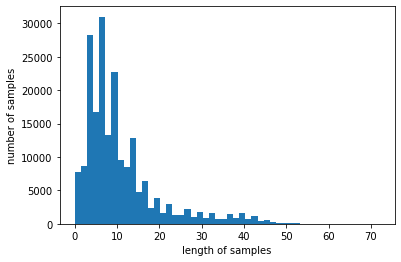

In [20]:
plt.hist([len(s) for s in tokenized_data], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# IV. Word2Vec 수행

> ## 1) 임베딩 학습

* Vector 차원 : 100
* Window 크기 : 5
* size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
* window = 컨텍스트 윈도우 크기
* min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
* workers = 학습을 위한 프로세스 수
* sg = 0은 CBOW, 1은 Skip-gram

In [21]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, 
                 size = 100, 
                 window = 5, 
                 min_count = 5, 
                 workers = 4, 
                 sg = 1)

> ## 2) 학습된 임베딩 매트릭스 크기 확인

In [22]:
model.wv.vectors.shape

(16477, 100)

# V. 임베딩 결과 테스트

In [23]:
model.wv.most_similar('이병헌')

[('최수종', 0.8179036974906921),
 ('공리', 0.8093166351318359),
 ('유다인', 0.8038285374641418),
 ('채민서', 0.8034932613372803),
 ('양동근', 0.8026297092437744),
 ('양조위', 0.7984650135040283),
 ('유오성', 0.7963012456893921),
 ('박상민', 0.7948091626167297),
 ('샤룩', 0.794766902923584),
 ('심은하', 0.7921613454818726)]

In [24]:
model.wv.most_similar('액션')

[('액션씬', 0.7522441148757935),
 ('코메', 0.7289121747016907),
 ('디도', 0.711840033531189),
 ('격투씬', 0.7098996639251709),
 ('레이싱', 0.7022179365158081),
 ('격투', 0.6973960995674133),
 ('스릴러물', 0.6912769079208374),
 ('무술', 0.6906458735466003),
 ('스타뎀', 0.6901156902313232),
 ('액션영화', 0.689139187335968)]

In [26]:
model.wv.most_similar('재미')

[('긴장도', 0.7115298509597778),
 ('잼', 0.668839693069458),
 ('재미없다', 0.6673956513404846),
 ('아무런', 0.6538657546043396),
 ('흥미', 0.6399649381637573),
 ('없슴', 0.6322859525680542),
 ('뭣', 0.6313347816467285),
 ('임팩트', 0.6295867562294006),
 ('젬', 0.6123777627944946),
 ('감흥', 0.6109907031059265)]

# VI. 사전훈련된 Word2Vec

> ## 1) Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/datasets/ko_w2v.zip

-rw------- 1 root root 80596565 May  4  2020 '/content/drive/My Drive/Colab Notebooks/datasets/ko_w2v.zip'


> ## 2) Unzip 'ko_w2v.zip'

In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/ko_w2v.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/ko_w2v.zip
  inflating: ko.bin                  
  inflating: ko.tsv                  


In [ ]:
!ls -l ko.bin

-rw------- 1 root root 50697568 Dec 21  2016 ko.bin


> ## 3) Word2Vec 가져오기

In [ ]:
import gensim

In [ ]:
model = gensim.models.Word2Vec.load('ko.bin')

> ## 4) Word2Vec Test

In [ ]:
model.wv.most_similar('금융')

[('감독원', 0.6556380391120911),
 ('신용', 0.6269841194152832),
 ('은행', 0.6236893534660339),
 ('외환', 0.6192121505737305),
 ('중소기업', 0.6051731705665588),
 ('중앙은행', 0.6050782799720764),
 ('증권', 0.5907014608383179),
 ('거래', 0.5898198485374451),
 ('투자', 0.5844753384590149),
 ('경영', 0.5692520141601562)]

In [ ]:
model.wv.most_similar('은행')

[('씨티', 0.6328796148300171),
 ('금융', 0.6236892938613892),
 ('농협', 0.6008170247077942),
 ('본점', 0.5930641889572144),
 ('한국은행', 0.5903059840202332),
 ('지점장', 0.5847948789596558),
 ('은행장', 0.5830198526382446),
 ('거래소', 0.5792121887207031),
 ('증권', 0.5775279998779297),
 ('외환', 0.5623738765716553)]

# 
# 
# 
# The End
# 
# 
# 